In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
import warnings

from ssl_wafermap.utilities.plotting import (
    init_seaborn_style,
    matplotlibify,
    ax_thiccify,
    legend_thiccify,
)

init_seaborn_style()

# Ignore warning about using plotly palettes in seaborn
warnings.filterwarnings("ignore", message=".*palette list.*")

In [2]:
def merge_dfs(source_path, save_path=None):
    """Merge all csv files in a directory into one dataframe"""
    all_dfs = []
    for file in os.listdir(source_path):
        df = pd.read_csv(os.path.join(source_path, file))

        # File name format: run-BYOL-tag-knn_accuracy.csv
        model_name = file.split("-")[1]
        # Some spelling mistakes:
        if model_name == "Moco":
            model_name = "MoCo"
        elif model_name == "SwaV":
            model_name = "SwAV"
        elif model_name == "MAE":
            continue # We only want MAE2
        elif model_name == "MAE2":
            model_name = "MAE"

        # We don't care about the wall time column
        df.drop(columns=["Wall time"], inplace=True)
        
        # Rename the value column to the model name
        df.rename(columns={"Value": model_name}, inplace=True)
        all_dfs.append(df)
    
    # Merge all dataframes into one
    # First, merge the first two dataframes
    merged_df = pd.merge(all_dfs[0], all_dfs[1], on=["Step"], how="left")
    # Then, merge the rest of the dataframes
    for df in all_dfs[2:]:
        merged_df = pd.merge(merged_df, df, on=["Step"], how="left")

    # In case of row count mismatch, interpolate missing values
    merged_df.interpolate(method="linear", inplace=True)

    # Save to file. As a sanity check, confirm read-file is the same.
    if save_path is not None:
        merged_df.to_pickle(f"{save_path}.pkl.xz", compression="xz")
    read_df = pd.read_pickle(f"{save_path}.pkl.xz")
    assert merged_df.equals(read_df), "Saved and read df are not the same!"

    return merged_df


root_dir = "../data/interim/model_logs/"
save_dir = "../data/processed/model_logs/"

f"{root_dir}/accuracy"

accuracy_df = merge_dfs(
    os.path.join(root_dir, "accuracy"), save_path=os.path.join(save_dir, "knn_accuracy")
)
f1_df = merge_dfs(
    os.path.join(root_dir, "f1"), save_path=os.path.join(save_dir, "knn_f1")
)
loss_df = merge_dfs(
    os.path.join(root_dir, "loss"), save_path=os.path.join(save_dir, "knn_loss")
)
rep_std_df = merge_dfs(
    os.path.join(root_dir, "rep_std"), save_path=os.path.join(save_dir, "knn_rep_std")
)

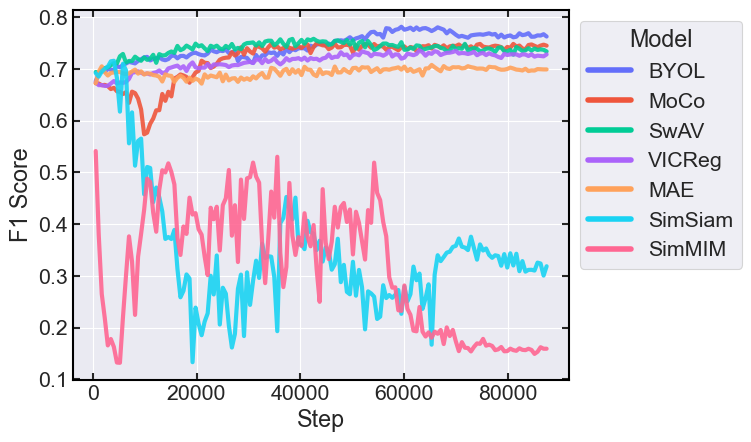

In [3]:
plot_columns = ["Step", "BYOL", "MoCo", "SwAV", "VICReg", "MAE", "SimSiam", "SimMIM"]

plot_df = pd.melt(
    f1_df[plot_columns], id_vars=["Step"], var_name="Model", value_name="F1 Score"
)

fig, ax = plt.subplots()
ax_thiccify(ax)
sns.lineplot(
    data=plot_df,
    x="Step",
    y="F1 Score",
    hue="Model",
    lw=3,
    alpha=0.9,
    legend="full",
    ax=ax,
    palette=px.colors.qualitative.Plotly,
)
legend_thiccify(ax, legend_title="Model")
plt.savefig("../reports/figures/knn_f1_seaborn.png", dpi=300, bbox_inches="tight")
plt.show()

In [4]:
fig = px.line(
    plot_df,
    x="Step",
    y="F1 Score",
    color="Model",
    width=700,
    height=400,
    color_discrete_sequence=px.colors.qualitative.Plotly,
)
fig.update_traces(line_width=4, opacity=0.9)
fig, scale = matplotlibify(fig, font_size=20)
fig.write_image("../reports/figures/knn_f1_plotly.png", scale=3)
fig.show()

## Code Graveyard 💀🪦

Conclusions:
- Use Arial font for consistency with matplotlib
- Seaborn template is nice
- px.colors.qualitative.D3 is a nice alternative to px.colors.qualitative.Plotly
- figure size scaling is much harder in plotly than with seaborn

In [5]:
# import plotly.express as px

# plot_df = pd.melt(f1_df[plot_columns], id_vars=["Step"], var_name="Model", value_name="F1 Score")
# fig = px.line(
#     plot_df,
#     x="Step",
#     y="F1 Score",
#     color="Model",
#     width=700,
#     height=400,
#     color_discrete_sequence=px.colors.qualitative.Plotly,
# )
# # set all margins except left to 0
# fig.update_layout(margin=dict(r=0, t=0, b=0), font_size=20, font_family="Dejavu Sans", template="seaborn")
# fig.update_traces(line_width=4, opacity=0.9)
# fig.write_image("fig.png", scale=3)
# fig.show()

# fig = px.line(
#     plot_df,
#     x="Step",
#     y="F1 Score",
#     color="Model",
#     width=700,
#     height=400,
#     color_discrete_sequence=px.colors.qualitative.D3)
# # set all margins except left to 0
# fig.update_layout(margin=dict(r=0, t=0, b=0), font_size=20, font_family="Arial", template="seaborn")
# fig.update_traces(line_width=4, opacity=0.9)
# fig.write_image("fig1.png", scale=3)
# fig.show()

In [6]:
# plot_df = pd.melt(f1_df[plot_columns], id_vars=["Step"], var_name="Model", value_name="F1 Score")
# fig = px.line(
#     plot_df,
#     x="Step",
#     y="F1 Score",
#     color="Model",
#     width=700,
#     height=400,
#     color_discrete_sequence=px.colors.qualitative.Plotly,
# )
# # set all margins except left to 0
# fig.update_layout(margin=dict(r=0, t=0, b=0), font_size=20, font_family="DejaVu Sans")
# fig.update_traces(line_width=4, opacity=0.9)
# # fig, scale = matplotlibify(fig)
# fig.write_image("fig5.png", scale=2.5)
# fig.show()

# fig = px.line(
#     plot_df,
#     x="Step",
#     y="F1 Score",
#     color="Model",
#     width=700,
#     height=400,
#     color_discrete_sequence=px.colors.qualitative.Plotly,
# )
# # set all margins except left to 0
# fig.update_traces(line_width=4, opacity=0.9)
# fig.update_layout(template="seaborn")
# fig, scale = matplotlibify(fig)
# fig.write_image("fig3.png", scale=scale)
# fig.show()

# fig = px.line(
#     plot_df,
#     x="Step",
#     y="F1 Score",
#     color="Model",
#     width=700,
#     height=400,
#     color_discrete_sequence=px.colors.qualitative.Plotly,
# )
# # set all margins except left to 0
# fig.update_traces(line_width=4, opacity=0.9)
# fig.update_layout(template="plotly")
# fig, scale = matplotlibify(fig)
# fig.write_image("fig4.png", scale=scale)
# fig.show()